### Notice
#### The original author's cost function has been modified: instead of maximizing p(x|z), the minimization of MSE (Mean Squared Error) is used.
#### The original code for GP-VAE can be found in the author's repository. https://github.com/ratschlab/GP-VAE

### Library import

In [1]:
import time
from datetime import datetime
import sys
import os

## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

tf.compat.v1.enable_eager_execution()
from Libs.GPVAE.models_varia_mse import *

Outdir = './Results/'
DATA = np.load("../Data/AsanTRSet.npy")


### Parameter setting

In [2]:
num_steps = 0 # 'Number of training steps: If non-zero it overwrites num_epochs'
num_epochs = 3000
batch_size = 500
print_interval = 0
TrRate = 0.8
LatDim = 10
learning_rate = 0.001

### Data processing

In [3]:
SigDim = DATA.shape[1]

np.random.seed(7)
PermutedDATA = np.random.permutation(DATA)
TrLen = int(PermutedDATA.shape[0] * TrRate)

TrData = PermutedDATA[:TrLen]
ValData = PermutedDATA[TrLen:]

TrDataFrame = tf.signal.frame(TrData, 100, 100).numpy()
ValDataFrame = tf.signal.frame(ValData, 100, 100).numpy()
# Split data on batches
x_val_batches = np.array_split(ValDataFrame, batch_size, axis=0)

data_dim = TrDataFrame.shape[-1]
time_length = TrDataFrame.shape[1]


if num_steps == 0:
    num_steps = num_epochs * len(TrDataFrame) // batch_size
else:
    num_steps = num_steps

if print_interval == 0:
    print_interval = num_steps // num_epochs

### Model build

In [4]:
encoder = BandedJointEncoderGRU
decoder = GaussianDecoder


model = GP_VAE(latent_dim=LatDim, 
               data_dim=data_dim, 
               time_length=time_length,
               encoder_sizes=[100, 80, 60], encoder=encoder,
               decoder_sizes=[60,80,100], decoder=decoder,
               kernel='cauchy', 
               sigma=1.,
               length_scale=1., 
               kernel_scales = 1,
               window_size=10,
               beta=1., M=1, K=1 )

_ = tf.compat.v1.train.get_or_create_global_step()
trainable_vars = model.get_trainable_vars()
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

print("Encoder: ", model.encoder.net.summary())
print("Decoder: ", model.decoder.net.summary())

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (1, 10, 100)              60600     
_________________________________________________________________
dense (Dense)                (1, 10, 80)               8080      
_________________________________________________________________
dense_1 (Dense)              (1, 10, 60)               4860      
_________________________________________________________________
dense_2 (Dense)              (1, 10, 30)               1830      
Total params: 75,370
Trainable params: 75,370
Non-trainable params: 0
_________________________________________________________________
Encoder:  None
Model: "sequential_1"
_______________________________________

### Load weights

In [5]:
if os.path.isfile(Outdir+'GPVAE_Encoder.hdf5'):
    model.encoder.net.load_weights(Outdir+'GPVAE_Encoder.hdf5')
if os.path.isfile(Outdir+'GPVAE_Decoder.hdf5'):
    model.decoder.net.load_weights(Outdir+'GPVAE_Decoder.hdf5')   


In [7]:
# Save imputed values
#z_mean = [model.encode(x_batch).mean().numpy() for x_batch in x_val_batches]

z_mean = []
for num, x_batch in enumerate(x_val_batches):
    print(num)
    z_mean.append(model.encode(x_batch).mean().numpy())


Recon = []
for num, z_batch in enumerate(z_mean):
    print(num)
    Recon.append(model.decode(z_batch).mean().numpy())
Recon = np.vstack(Recon)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

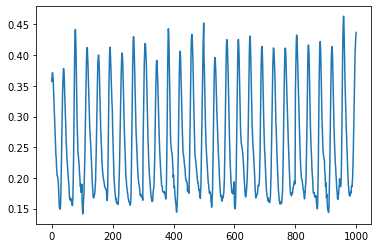

In [9]:
plt.plot(Recon[0].ravel())


### Evaluation 

In [11]:
N_Gen = 300
zLoc = [0,1]
TimeN = 10
MinZval = -3
MaxZval = 3

zVal = np.zeros((N_Gen,TimeN, LatDim))
zVal_t = np.tile(np.linspace(MinZval, MaxZval, N_Gen)[:, None], TimeN)

for loc in zLoc:
    zVal[:,loc] = zVal_t

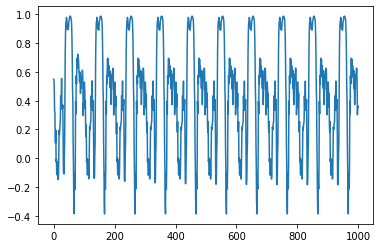

In [12]:
tmp = model.decode(zVal[1:2]).mean().numpy()
plt.plot(tmp.ravel())


Finished in 0.006561 sec


c:\users\user\anaconda3\envs\ai\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


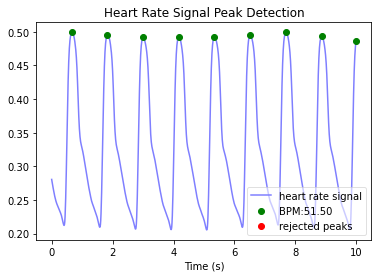

In [38]:
import heartpy as hp
data = hp.load_exampledata(0)
fs = 100.0 #example file 0 is sampled at 100.0 Hz

working_data, measures = hp.process(TrData[900], fs, report_time=True)
hp.plotter(working_data, measures)
